<a href="https://colab.research.google.com/github/rokmr/Computer-Vision/blob/main/src/Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import cv2

# Device Agnostic

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#DATA

In [3]:
#Transform
transform = transforms.ToTensor()

In [4]:
%%capture
train_mnist_data = datasets.MNIST(root = 'data', train=True, download=True, transform= transform)
test_mnist_data = datasets.MNIST(root = 'data', train=False, download=True, transform= transform)

In [5]:
# Taking subset of te data
train_data = list(train_mnist_data)
test_data = list(test_mnist_data)

In [6]:
image, _ = train_mnist_data[0]
image.shape

torch.Size([1, 28, 28])

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

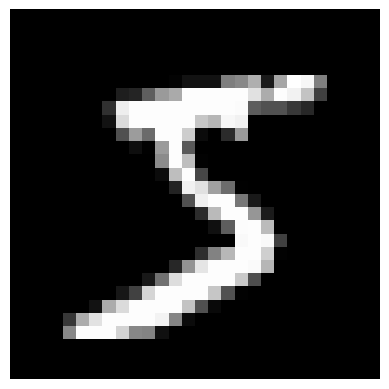

In [7]:
plt.imshow(image.squeeze(), cmap= 'gray')
plt.axis(False)

In [8]:
# Checking our data is itin [0,1] or [0,255]
print(image.max())
print(image.min())

tensor(1.)
tensor(0.)


******
Our data is in [0,1] form
******

# AUTO ENCODER

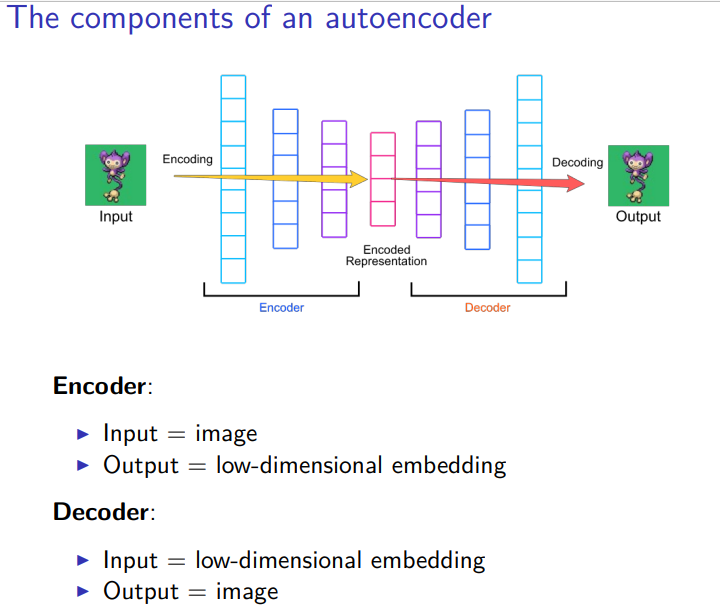

******
**Components:**

An encoder that takes an image as input, and outputs a low-dimensional embedding (representation) of the image.

A decoder that takes the low-dimensional embedding, and reconstructs the image.
******
Dimension reduction: find a low dimensional representation of the image

Image Generation: Generate new images not in the training set
******
**Training:**

If we pass an image through the encoder, then pass the result through the decoder, we should get roughly the same image back. Ideally, reducing the dimensionality and then generating the image should give us the same result.

We will minimize the reconstruction error of the autoencoder across our training data.
******

# FUCTIONS

In [9]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=1e-5) # <--
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    outputs = []
    LOSS = []
    for epoch in tqdm(range(num_epochs)):
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        LOSS.append(float(loss))
        print(f'Epoch:{epoch+1} || Loss:{float(loss):.4f}')
        outputs.append((epoch, img, recon),)                # appending as tuple
    return outputs, LOSS

In [10]:
def plotter(outputs:list, LOSS:list):

  plt.plot(list(range(1, max_epochs+1)), LOSS)
  plt.title("LOSS VS EPOCHS")
  plt.show()
  for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    plt.suptitle(f"Epoch No.: {k}")
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0], cmap='gray')
        plt.axis(False)

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0],cmap='gray')
        plt.axis(False)

    plt.tight_layout()
  plt.show()

#LINEAR MODEL BASED AUTO ENCOEDER

In [11]:
class Autoencoder_Linear_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [12]:
model_LM = Autoencoder_Linear_Model().to(device)
max_epochs = 20
outputs, LOSS = train(model_LM, num_epochs=max_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:1 || Loss:0.0545
Epoch:2 || Loss:0.0389
Epoch:3 || Loss:0.0325
Epoch:4 || Loss:0.0363
Epoch:5 || Loss:0.0350
Epoch:6 || Loss:0.0387
Epoch:7 || Loss:0.0347
Epoch:8 || Loss:0.0381
Epoch:9 || Loss:0.0356
Epoch:10 || Loss:0.0332
Epoch:11 || Loss:0.0387
Epoch:12 || Loss:0.0352
Epoch:13 || Loss:0.0385
Epoch:14 || Loss:0.0289
Epoch:15 || Loss:0.0334
Epoch:16 || Loss:0.0321
Epoch:17 || Loss:0.0352
Epoch:18 || Loss:0.0407
Epoch:19 || Loss:0.0348
Epoch:20 || Loss:0.0284


LINEAR MODEL BASED AUTOENCODER


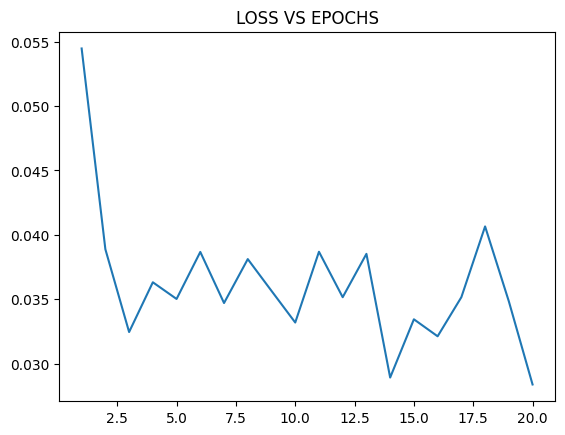

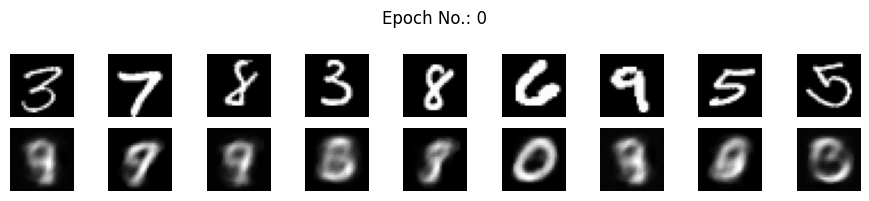

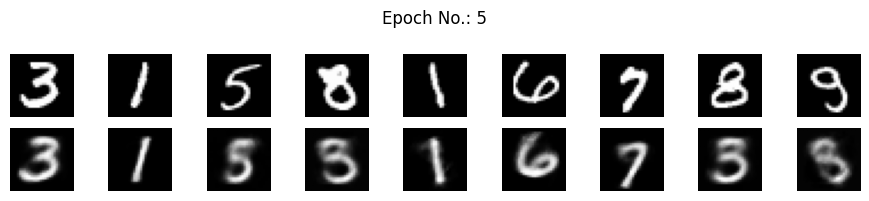

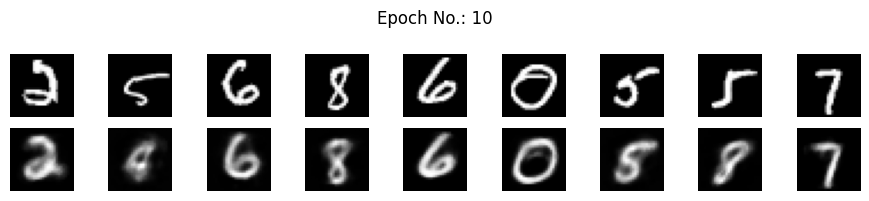

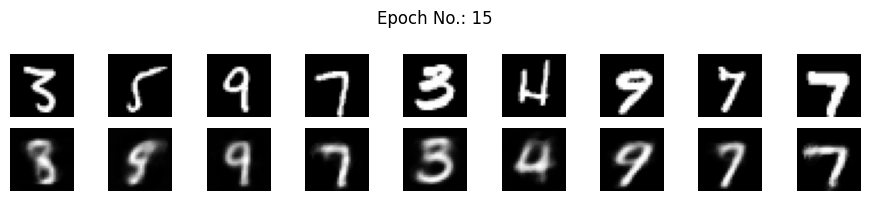

In [13]:
print("LINEAR MODEL BASED AUTOENCODER")
plotter(outputs, LOSS)

******
For this dataset, te vary simple autoencoder with some linear layer and vary less epoch the model performance was quite good.
******

#CNN BASED AUTO ENCOEDER

In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
model_CNN = Autoencoder().to(device)
max_epochs = 20
outputs, LOSS = train(model_CNN, num_epochs=max_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:1 || Loss:0.0135
Epoch:2 || Loss:0.0061
Epoch:3 || Loss:0.0043
Epoch:4 || Loss:0.0044
Epoch:5 || Loss:0.0033
Epoch:6 || Loss:0.0029
Epoch:7 || Loss:0.0033
Epoch:8 || Loss:0.0032
Epoch:9 || Loss:0.0028
Epoch:10 || Loss:0.0033
Epoch:11 || Loss:0.0032
Epoch:12 || Loss:0.0029
Epoch:13 || Loss:0.0031
Epoch:14 || Loss:0.0027
Epoch:15 || Loss:0.0025
Epoch:16 || Loss:0.0023
Epoch:17 || Loss:0.0029
Epoch:18 || Loss:0.0033
Epoch:19 || Loss:0.0030
Epoch:20 || Loss:0.0025


CNN BASED AUTOENCODER


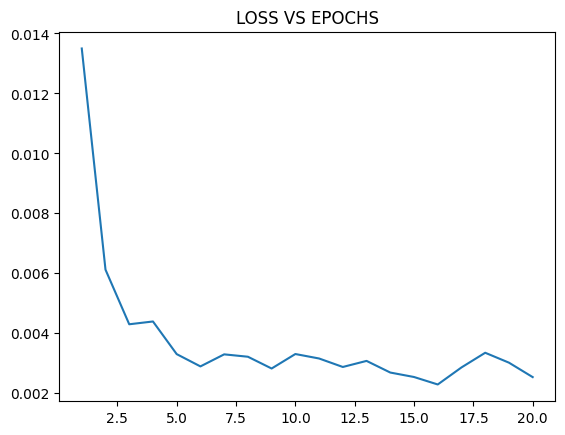

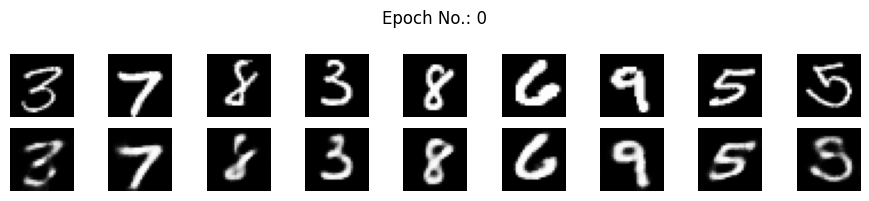

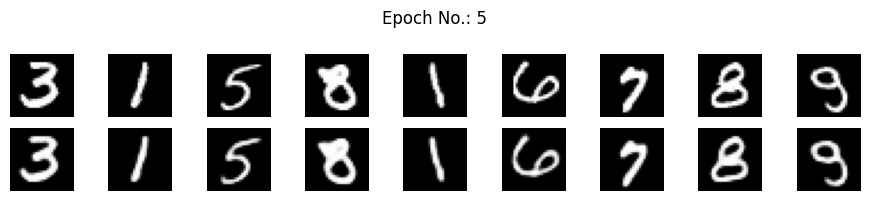

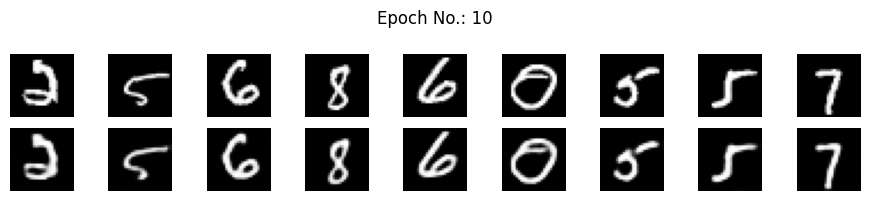

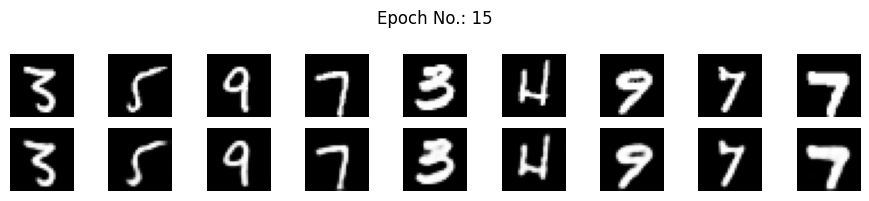

In [16]:
print("CNN BASED AUTOENCODER")
plotter(outputs, LOSS)

******
The CNN-based performed better than the linear layer based model.
******

# Using CNN based model for different dataset

In [17]:
%%capture
FashionMNIST = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
    target_transform=None
)

In [18]:
input_image, _ = FashionMNIST[0]
input_image = input_image.to(device)
output_image = model_CNN(input_image)

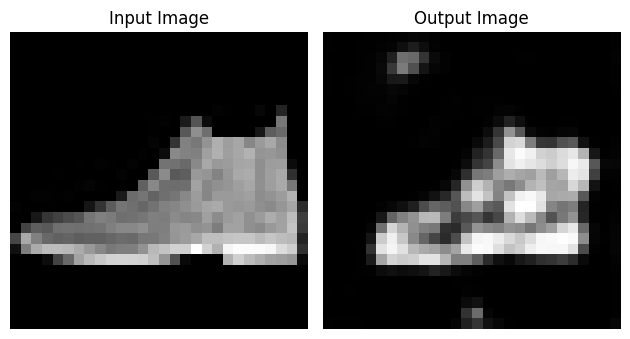

In [19]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(input_image.squeeze().cpu(),cmap='gray')
plt.title("Input Image")
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(output_image.squeeze().detach().cpu(),cmap='gray')
plt.title("Output Image")
plt.axis(False)
plt.tight_layout()
plt.show()

******
From the above outputwe can conclude that:

It is possible to have a good reconstruction of an arbitrary image in autoencoder.
******